# Traffic Violation RAG System
In this exam, you will implement a Retrieval-Augmented Generation (RAG) system that uses a language model and a vector database to answer questions about traffic violations. The goal is to generate answers with relevant data based on a dataset of traffic violations and fines.

Here are helpful resources:
* [LangChain](https://www.langchain.com/)
* [groq cloud documentation](https://console.groq.com/docs/models)
* [LangChain HuggingFace](https://python.langchain.com/docs/integrations/text_embedding/sentence_transformers/)
* [Chroma Vector Store](https://python.langchain.com/docs/integrations/vectorstores/chroma/)
* [Chroma Website](https://docs.trychroma.com/getting-started)
* [ChatGroq LangChain](https://python.langchain.com/docs/integrations/chat/groq/)
* [LLM Chain](https://api.python.langchain.com/en/latest/chains/langchain.chains.llm.LLMChain.html#langchain.chains.llm.LLMChain)

Dataset [source](https://www.moi.gov.sa/wps/portal/Home/sectors/publicsecurity/traffic/contents/!ut/p/z0/04_Sj9CPykssy0xPLMnMz0vMAfIjo8ziDTxNTDwMTYy83V0CTQ0cA71d_T1djI0MXA30gxOL9L30o_ArApqSmVVYGOWoH5Wcn1eSWlGiH1FSlJiWlpmsagBlKCQWqRrkJmbmqRqUZebngB2gUJAKdERJZmqxfkG2ezgAhzhSyw!!/)

Some installs if needed:
```python
!pip install langchain_huggingface langchain langchain-community langchain_chroma Chroma langchain_groq LLMChain
```

- THE LLMCHAIN CAUSED ME AN ERRIR, SO I REMOVED IT.

In [2]:
!kaggle datasets download -d khaledzsa/dataset
!unzip dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/dataset
License(s): unknown
  0% 0.00/3.73k [00:00<?, ?B/s]
100% 3.73k/3.73k [00:00<00:00, 10.3MB/s]
Archive:  dataset.zip
  inflating: Dataset.csv             


## Step 1: Install Required Libraries

In [15]:
!pip install langchain_huggingface langchain langchain_community langchain_chroma Chroma langchain_groq

  Using cached langchain_huggingface-0.1.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached langchain-0.3.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached langchain_community-0.3.0-py3-none-any.whl.metadata (2.8 kB)
  Using cached langchain_chroma-0.1.4-py3-none-any.whl.metadata (1.6 kB)
  Using cached Chroma-0.2.0.tar.gz (5.8 kB)
  Preparing metadata (setup.py) ... done
  Using cached langchain_groq-0.2.0-py3-none-any.whl.metadata (2.9 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.2/599.2 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

To begin, install the necessary libraries for this project. The libraries include `LangChain` for building language model chains, and `Chroma` for managing a vector database.

## Step 1.2 : Import Required Libraries

In [29]:
import pandas as pd
import os
from langchain.text_splitter import RecursiveCharacterTextSplitter
import markdown
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain_groq import ChatGroq
from langchain import LLMChain


In [33]:
from langchain.chains import LLMChain

# Step 2: Load the Traffic Violations Dataset

You are provided with a dataset of traffic violations. Load the CSV file into a pandas DataFrame and preview the first few rows of the dataset using `.head()`. You can also try and see the dataset's characteristics.

In [5]:
df = pd.read_csv("/content/Dataset.csv")
df

,المخالفة,الغرامة
0,قيادة المركبة في الأسواق التي لا يسمح بالقيادة...,الغرامة المالية 100 - 150 ريال
1,ترك المركبة مفتوحة وفي وضع التشغيل بعد مغادرتها.,الغرامة المالية 100 - 150 ريال
2,عدم وجود تأمين ساري للمركبة.,الغرامة المالية 100 - 150 ريال
3,عبور المشاة للطرق من غير الأماكن المخصصة لهم.,الغرامة المالية 100 - 150 ريال
4,عدم تقيد المشاة بالإشارات الخاصة بهم.,الغرامة المالية 100 - 150 ريال
...,...,...
99,القيام بأعمال الطرق قبل التنسيق مع الإدارة الم...,الغرامة المالية 5000 - 10000 ريال
100,سماح أصحاب الحيوانات بعبور حيواناتهم من غير ال...,الغرامة المالية 5000 - 10000 ريال
101,استخدام لوحات غير عائدة للمركبة.,الغرامة المالية 5000 - 10000 ريال
102,طمس رقم هيكل المركبة أو محاولة طمسه.,الغرامة المالية 5000 - 10000 ريال


In [6]:
df.head()

,المخالفة,الغرامة
0,قيادة المركبة في الأسواق التي لا يسمح بالقيادة...,الغرامة المالية 100 - 150 ريال
1,ترك المركبة مفتوحة وفي وضع التشغيل بعد مغادرتها.,الغرامة المالية 100 - 150 ريال
2,عدم وجود تأمين ساري للمركبة.,الغرامة المالية 100 - 150 ريال
3,عبور المشاة للطرق من غير الأماكن المخصصة لهم.,الغرامة المالية 100 - 150 ريال
4,عدم تقيد المشاة بالإشارات الخاصة بهم.,الغرامة المالية 100 - 150 ريال


In [7]:
df.shape

(104, 2)

In [11]:
df.columns


Index(['المخالفة', 'الغرامة'], dtype='object')

In [12]:
print(len(df))

104


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   المخالفة  104 non-null    object
 1   الغرامة   104 non-null    object
dtypes: object(2)
memory usage: 1.8+ KB


## Step 3: Create Markdown Content from the Dataset

For each traffic violation in the dataset, you will generate markdown text that describes the violation and the associated fine. Create a loop to iterate through the dataset and store the generated markdown in a list. Each fine should look like this:

**المخالفة** - الغرامة

In [9]:
directory = 'data/markdown_files'
os.makedirs(directory, exist_ok=True)

In [13]:
for i in range(len(df)):
    fine = df['الغرامة'].iloc[i]
    violation = df['المخالفة'].iloc[i]

    markdown_content = f"# {fine}\n\n"
    markdown_content += f"{violation}\n\n"

    with open(f'{directory}/{i}.md', 'w', encoding='utf-8') as file:
        file.write(markdown_content)

This is how it looks: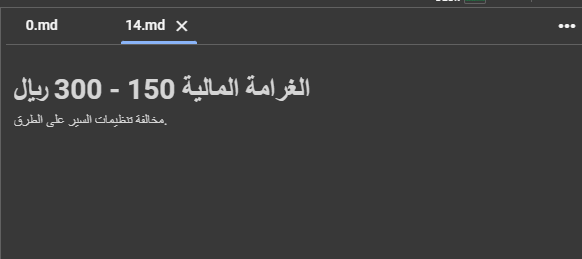

## Step 4: Chunk the Markdown Data

Using LangChain's `RecursiveCharacterTextSplitter`, split the markdown texts into smaller chunks that will be stored in the vector database.

In [18]:
texts = []

for filename in os.listdir(directory):
  if filename.endswith(".md"):
    with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:

      markdown_content = file.read()
      html_content = markdown.markdown(markdown_content)
      texts.append(html_content)

In [30]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100,
                                               chunk_overlap=20)

docs = text_splitter.create_documents(texts)

## Step 5: Generate Embeddings for the Documents

Generate embeddings for the chunks of text using HuggingFace's pre-trained Arabic language model. These embeddings will be stored in a `Chroma` vector store.

In [23]:
embeddings = SentenceTransformerEmbeddings(model_name='aubmindlab/bert-base-arabertv2')

chroma = Chroma.from_documents(docs,
                               embeddings,
                               persist_directory="./chroma_db")

<ipython-input-23-55e8c508c0f8>:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  embeddings = SentenceTransformerEmbeddings(model_name='aubmindlab/bert-base-arabertv2')
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (htt

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Step 6: Define the RAG Prompt Template

Define a custom prompt template in Arabic to retrieve traffic violation-related answers based on the context. Ensure the template encourages the model to give **advice** in **Arabic**, staying within the context provided.

In [35]:
PROMPT_TEMPLATE = """
You are a specialized police officer, you will answer all questions based on the context provided:
YOU WILL ANSWER ONLY IN ARABIC.

Context: {context}
Question: {question}

Your answer:
"""

# Define the prompt template
prompt = PromptTemplate(
    template=PROMPT_TEMPLATE,
    input_variables=['context', 'question']
)

## Step 7: Initialize the Language Model

Initialize the language model using the Groq API. Set up the model with a specific configuration, including the API key, temperature setting, and model name.

In [36]:
groq_api = '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'

llm_model = ChatGroq(temperature=0,
               groq_api_key=groq_api,
               model_name='llama3-8b-8192')

## Step 8: Create the LLM Chain

Now, you will create an LLM Chain that combines the language model and the prompt template you defined. This chain will be used to generate responses based on the retrieved context.

In [38]:
CHAIN_MODEL = LLMChain(
    llm=llm_model,
    prompt=prompt,
    verbose=True
)

## Step 9: Implement the Query Function

Create a function `query_rag` that will take a user query as input, retrieve relevant context from the vector store, and use the language model to generate a response based on that context.

In [39]:
def query_rag(input_query: str):

  similarity_search_results = chroma.similarity_search_with_score(input_query, k=3)

  context_text = '\n\n'.join([doc.page_content for doc, _score in similarity_search_results])

  response = CHAIN_MODEL.invoke({'context': context_text,
                           'question': input_query})

  return response

## Step 10: Inference - Running Queries in the RAG System

In this final step, you will implement an inference pipeline to handle real-time queries. You will allow the system to retrieve the most relevant violations and fines based on a user's input and generate a response.

1. Inference Workflow:

  * The user inputs a query (e.g., "ماهي الغرامة على القيادة بدون رخصة؟").
  * The system searches for the most relevant context from the traffic violation vector store.
  * It generates an answer and advice based on the context.

2. Goal:
  * Run the inference to answer questions based on the traffic violation dataset.

In [42]:
user_input  = 'ماهي الغرامة على القيادة بدون رخصة'

response = query_rag(user_input)

response

Prompt after formatting:

You are a specialized police officer, you will answer all questions based on the context provided:
YOU WILL ANSWER ONLY IN ARABIC.

Context: <p>عدم التقيد بإشارات رجل الأمن اليدوية عند تنظيمه للحركة وعدم إعطاء إشارته الأولوية على الإشارات

<p>زيادة أبعاد الحمولة المنقولة لمركبات النقل الثقيل على الحد المسموح به.</p>

في حال سيرها على المسارات المخصصة لها.</p>
Question: ماهي الغرامة على القيادة بدون رخصة

Your answer:


> Finished chain.


{'context': '<p>عدم التقيد بإشارات رجل الأمن اليدوية عند تنظيمه للحركة وعدم إعطاء إشارته الأولوية على الإشارات\n\n<p>زيادة أبعاد الحمولة المنقولة لمركبات النقل الثقيل على الحد المسموح به.</p>\n\nفي حال سيرها على المسارات المخصصة لها.</p>',
 'question': 'ماهي الغرامة على القيادة بدون رخصة',
 'text': 'الغرامة على القيادة بدون رخصة هي 500 ريال.'}

In [44]:
print(f'''Context:\n{response["context"]}
      \nQuestion:\n{response["question"]}
      \nText: \n{response["text"]}''')

Context:
<p>عدم التقيد بإشارات رجل الأمن اليدوية عند تنظيمه للحركة وعدم إعطاء إشارته الأولوية على الإشارات

<p>زيادة أبعاد الحمولة المنقولة لمركبات النقل الثقيل على الحد المسموح به.</p>

في حال سيرها على المسارات المخصصة لها.</p>
      
Question:
ماهي الغرامة على القيادة بدون رخصة
      
Text: 
الغرامة على القيادة بدون رخصة هي 500 ريال.
